# A Naive Bayes Classifier

In [146]:
import numpy as np
np.seterr(divide='ignore') # happy with log(0) = -inf
from math import log, pi

class NBC:
    def __init__(self, feature_types):
        self.feature_types = feature_types
    
    def fit(self, X, y):
        if hasattr(self, "logpi"):
            raise Exception("Already fitted")
        if X.shape[1] != len(self.feature_types):
            raise Exception("Wrong number of features")
                    
        self.classes = np.unique(y)
        self.class_map = {v: k[0] for k, v in np.ndenumerate(self.classes)}
                    
        self.logpi = np.log([np.count_nonzero(y == c) for c in self.classes]) - log(y.shape[0])
        
        means = []
        stddevs = []
        for c in self.classes:
            X_ = X[np.where(y == c)]
            means.append(np.mean(X_, axis = 0))
            stddevs.append(np.std(X_, axis = 0))
        self.means = np.array(means)
        self.stddevs = np.array(stddevs)
        
    def predict(self, X):
        N, f = X.shape
        if f != len(self.feature_types):
            raise Exception("Wrong number of features")       
        
        # P[i, class] = log(P(X[i] | class))
        P = np.zeros((N,self.classes.size))
        
        # Add the priors
        P += self.logpi
                
        # Add log(P(X[i, feature, class) | mean[feature, class])) to the probabilites
        b = np.where(self.feature_types == 'b')
        g = np.where(self.feature_types == 'r')
        for c in range(self.classes.size):
            P_b = X[:, b]*np.log(self.means[c, b]) + (1-X[:, b]) * np.log(1-self.means[c, b])
            P_r = -1/2*np.log(2*pi*self.stddevs[c, g]) - (X[:, g]-self.means[c, g])**2/2/self.stddevs[c, g]
            
            P[:, c] = P[:, c] + np.sum(P_b, axis = 2).reshape((N,)) + np.sum(P_r, axis = 2).reshape((N,))
            
        y = np.argmax(P, axis=1)
        # y[i] == argmax_c P(X[i] | c)
                
        return self.classes[y]

# LR Regularisation
In `LogisticRegression` the parameter $C$ is multiplied with everything but the regularization term of the optimization function, so setting $C = \lambda^{-1}$ gives the same minimum as multiplying $\lambda$ with the regularization term.

In [147]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

def trainAndReportError(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    return np.mean(classifier.predict(X_train) == y_train)

def compare(X, y, features):
    index_series = range(10, 101, 10)
    nbc_series = np.zeros(len(index_series))
    lr_series = np.zeros(len(index_series))
    
    runs = 1000
    for run in range(runs):
        N, D = X.shape
        Ntrain = int(0.8 * N)
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]
        nbc_errors = [trainAndReportError(NBC(features), Xtrain[:Ntrain*i/100], ytrain[:Ntrain*i/100], Xtest, ytest) 
                      for i in index_series]
        lr_errors = [trainAndReportError(LogisticRegression(C = 10), Xtrain[:Ntrain*i/100], ytrain[:Ntrain*i/100], Xtest, ytest) 
                     for i in index_series]
        nbc_series += np.array(nbc_errors)
        lr_series += np.array(lr_errors)
        
    nbc_series /= runs
    lr_series /= runs

    plt.plot(index_series, nbc_series, 'b')
    plt.plot(index_series, lr_series, 'r')
    plt.show()

# Iris Dataset
We're plotting testing error for NBC (blue) and LR (red) against the percentage of the training set that the classifiers were trained on.

/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in divide
/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in subtract


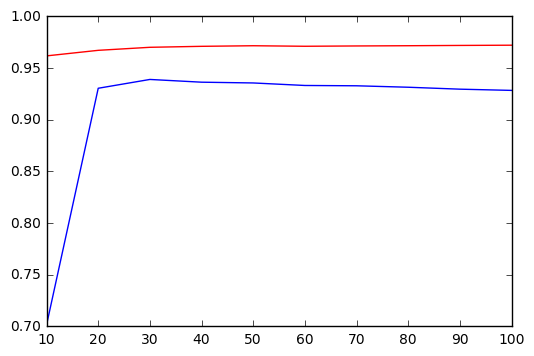

In [148]:
from sklearn.datasets import load_iris
iris = load_iris()
compare(iris['data'], iris['target'], np.repeat('r', 4))

# Congress Dataset
We're plotting testing error for NBC (blue) and LR (red) against the percentage of the training set that the classifiers were trained on.

/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in multiply


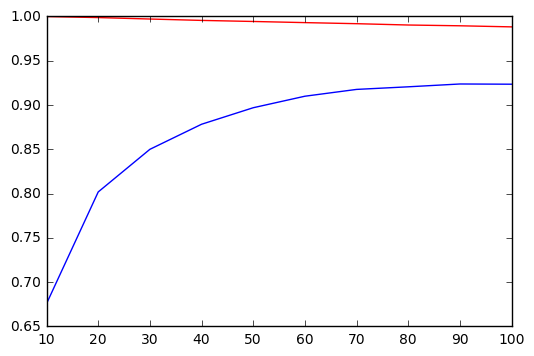

In [149]:
import cPickle as cp
X, y = cp.load(open('data/voting.cPickle', 'rb'))
compare(X, y, np.repeat('b', X.shape[1]))